Audio enginering basics

Load Audio + Inspect Basics

In [10]:
from pydub import AudioSegment

In [11]:
audio = AudioSegment.from_file("song.mp3")

In [12]:
print("Duration (ms):", len(audio))
print("Channels:", audio.channels)
print("Frame Rate:", audio.frame_rate)
print("Sample Width (bytes):", audio.sample_width)
print("dBFS (average loudness):", audio.dBFS)

Duration (ms): 328028
Channels: 2
Frame Rate: 44100
Sample Width (bytes): 2
dBFS (average loudness): -11.418358279354736


2. Slicing Audio (Show Output Sizes)

In [13]:
first_5_sec = audio[:5000]
next_5_sec = audio[5000:10000]

print("First 5 sec duration:", len(first_5_sec))
print("Next 5 sec duration:", len(next_5_sec))

First 5 sec duration: 5000
Next 5 sec duration: 5000


3. Fade In / Fade Out Demo

In [14]:
fade_in_clip = audio[:5000].fade_in(3000)
fade_out_clip = audio[:5000].fade_out(3000)

print("Fade-in clip:", fade_in_clip)
print("Fade-out clip:", fade_out_clip)

Fade-in clip: <pydub.audio_segment.AudioSegment object at 0x000001D998947580>
Fade-out clip: <pydub.audio_segment.AudioSegment object at 0x000001D99A117CA0>


4. Concatenation Demo

how to join 2 songs

In [15]:
combined = first_5_sec + next_5_sec
print("Combined length:", len(combined))

Combined length: 10000


6. SIMPLE Waveform Plot Using Librosa + Matplotlib

Peaks = loud parts

Valleys = quiet parts

They visually understand fade, slicing, transitions

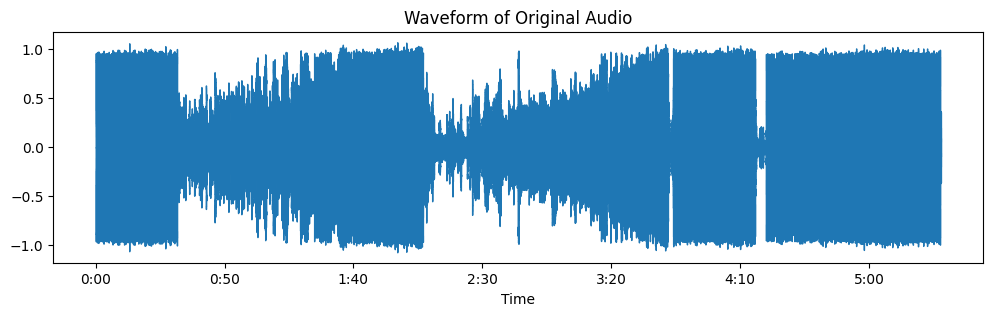

In [16]:
import librosa
import librosa.display
import matplotlib.pyplot as plt

y , sr = librosa.load("song.mp3" , sr= None)

plt.figure(figsize=(12, 3))
librosa.display.waveshow(y, sr=sr)
plt.title("Waveform of Original Audio")
plt.show()

7. Visualize Fade-In vs Fade-Out

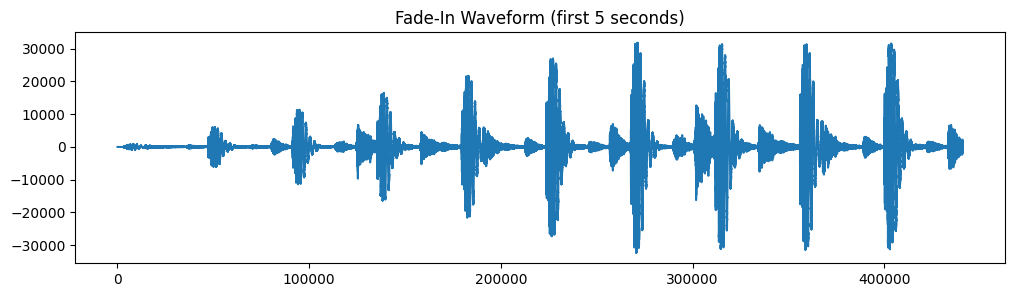

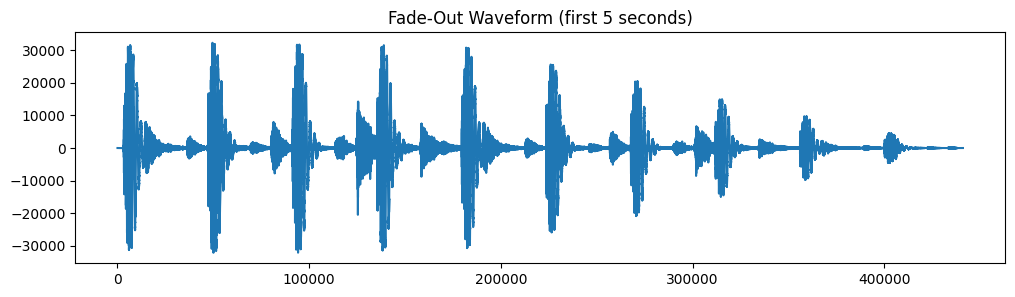

In [17]:
fade_in_audio = fade_in_clip.get_array_of_samples()
fade_out_audio = fade_out_clip.get_array_of_samples()

plt.figure(figsize=(12, 3))
plt.plot(fade_in_audio)
plt.title("Fade-In Waveform (first 5 seconds)")
plt.show()

plt.figure(figsize=(12, 3))
plt.plot(fade_out_audio)
plt.title("Fade-Out Waveform (first 5 seconds)")
plt.show()

LOGIC

In [3]:
from pydub import AudioSegment
import os, random

MIXTAPE GENERATOR

In [4]:
def smooth_fade_mixtape(folder, output="output/mixtape.mp3", transition_ms=6000):
    files = [f for f in os.listdir(folder) if f.endswith((".mp3", ".wav"))]
    random.shuffle(files)  # shuffle for variety
    
    mixtape = None
    for i, file in enumerate(files):
        song = AudioSegment.from_file(os.path.join(folder, file))
        song = song.set_channels(2).set_frame_rate(44100)  # stereo
        
        if mixtape is None:
            mixtape = song
        
        else:
            # define overlap region
            overlap = min(transition_ms, len(song), len(mixtape))
            
            # outgoing: fade out + high-pass to remove bass
            outgoing = mixtape[-overlap:].fade_out(overlap).low_pass_filter(4000)
        
            # incoming: fade in + low-pass to smooth highs
            incoming = song[:overlap].fade_in(overlap).low_pass_filter(4000)
            
            # overlay transition
            transition = outgoing.overlay(incoming)
            
            mixtape = mixtape[:-overlap] + transition + song[overlap:]
            
    mixtape.export(output, format="mp3")
    print(f"✅ Smooth fade mixtape generated: {output}")
    
smooth_fade_mixtape("mixtape")

✅ Smooth fade mixtape generated: output/mixtape.mp3


DESCRIPTION GENERATOR

In [8]:
import os
from pydub import AudioSegment

def generate_youtube_description_with_timestamps(track_folder, mixtape_name="Afro House Mixtape", genre="Afro House", start_time_sec=0):
    """
    Generates a YouTube description with tracklist, timestamps, and hashtags.
    Assumes audio files are in order of playback.
    """
    audio_extensions = (".mp3", ".wav", ".flac", ".aac", ".ogg", ".m4a")
    tracks = [f for f in os.listdir(track_folder) if f.lower().endswith(audio_extensions)]
    if not tracks:
        return "No audio tracks found in the folder!"

    tracks.sort()  # optional: sort alphabetically

    description = f"🔥 {mixtape_name} 🔥\n"
    description += f"Genre: {genre}\n\n"
    description += "🎵 Tracklist:\n"

    current_time = start_time_sec

    for idx, track in enumerate(tracks, 1):
        track_path = os.path.join(track_folder, track)
        audio = AudioSegment.from_file(track_path)
        duration_sec = len(audio) // 1000  # duration in seconds

        # Format timestamp mm:ss
        minutes = current_time // 60
        seconds = current_time % 60
        timestamp = f"{minutes:02d}:{seconds:02d}"

        track_name = os.path.splitext(track)[0]
        description += f"{timestamp} - {track_name}\n"

        current_time += duration_sec  # increment for next track

    description += "\n💽 Download/Listen links:\n"
    description += "You can find these tracks online or on Spotify/Apple Music.\n\n"
    description += "🎧 Follow for more Afro House mixes!\n\n"

    hashtags = [
        "#AfroHouse", "#HouseMusic", "#EDM", "#DanceMusic", "#Mixtape",
        "#ElectronicMusic", "#DJMix", "#PartyMusic", "#DeepHouse", "#AfroHouseVibes"
    ]
    description += " ".join(hashtags)

    return description

# Example usage
track_folder = r"mixtape"
description_text = generate_youtube_description_with_timestamps(
    track_folder,
    mixtape_name="Afro House Summer Mix",
    genre="Afro House"
)

print(description_text)

# Optional: save to file
with open("youtube_description.txt", "w", encoding="utf-8") as f:
    f.write(description_text)


🔥 Afro House Summer Mix 🔥
Genre: Afro House

🎵 Tracklist:
00:00 - yt1s.com - Awen  Caiiro  Your Voice Adam Port Remix MIDH 043
04:20 - yt1s.com - Waves  Wavs

💽 Download/Listen links:
You can find these tracks online or on Spotify/Apple Music.

🎧 Follow for more Afro House mixes!

#AfroHouse #HouseMusic #EDM #DanceMusic #Mixtape #ElectronicMusic #DJMix #PartyMusic #DeepHouse #AfroHouseVibes


VIDEO GENERATOR

The function takes an image and an audio file, resizes the image to a fixed video resolution, and saves it temporarily. It then builds an FFmpeg command that loops the image, combines it with the audio, and encodes the result using H.264 video and AAC audio. A very low FPS and the ultrafast preset are used to make rendering extremely fast, since the visual is static. FFmpeg creates an MP4 video that lasts exactly as long as the audio. After the video is generated, the temporary resized image is deleted.

In [14]:
import subprocess
import os
from PIL import Image

In [15]:
def make_video_from_audio_optimized(image_path, audio_path, output_path="output/mixtape_vid3.mp4",
                                    video_resolution=(1280, 720), fps=1, preset="ultrafast"):
    
    
    if not os.path.exists(image_path):
        raise FileNotFoundError(f"Image not found: {image_path}")
    if not os.path.exists(audio_path):
        raise FileNotFoundError(f"Audio not found: {audio_path}")
    
    # Ensure output folder exists
    os.makedirs(os.path.dirname(output_path), exist_ok=True)
    
    # Resize image if necessary
    img_resized_path = "temp_resized_image.jpg"
    img = Image.open(image_path)
    img = img.resize(video_resolution)
    img.save(img_resized_path)
    
    # FFmpeg command
    cmd = [
        "ffmpeg",              # invoke FFmpeg program
        "-y",                  # overwrite output file without asking
        "-loop", "1",          # loop the input image (so it stays on screen)
        "-i", img_resized_path,  # input #1: the static image
        "-i", audio_path,        # input #2: the audio track (mp3/wav/etc.)
        "-c:v", "libx264",       # encode video using H.264 codec
        "-preset", preset,       # encoding speed/quality preset (e.g. 'fast', 'medium')
        "-tune", "stillimage",   # optimize encoding for a static image
        "-r", str(fps),          # set frames per second (low = smaller file)
        "-c:a", "aac",           # encode audio using AAC codec
        "-b:a", "192k",          # set audio bitrate to 192kbps
        "-shortest",             # stop encoding when the shortest input ends (audio ends)
        output_path              # output file path (e.g. .mp4)
    ]
    
    try:
        subprocess.run(cmd, check=True)
        print(f"✅ Video created: {output_path}")
    except subprocess.CalledProcessError as e:
        print("❌ FFmpeg failed! Error:", e)
    finally:
        # Clean up temporary resized image
        if os.path.exists(img_resized_path):
            os.remove(img_resized_path)
        

# Example usage
image_path = r"images/image.png"
audio_path = r"output/mixtape.mp3"
make_video_from_audio_optimized(image_path, audio_path)    

✅ Video created: output/mixtape_vid3.mp4
